# load data

In [1]:
import numpy as np
import pandas as pd
!cp /content/drive/MyDrive/muscle_promoter/utils.py .
from utils import *

In [2]:
X_train = np.load('/content/drive/MyDrive/muscle_promoter/training_data/X_train.npy', allow_pickle=True)
X_val = np.load('/content/drive/MyDrive/muscle_promoter/training_data/X_val.npy', allow_pickle=True)
X_test = np.load('/content/drive/MyDrive/muscle_promoter/training_data/X_test.npy', allow_pickle=True)

transform data

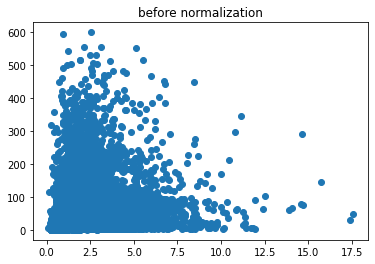

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X_train.T[0], X_train.T[2000])
plt.title('before normalization')
plt.show()

In [4]:
X_train, X_val, X_test = normalize_data(X_train, X_val, X_test)
print(X_train.shape, X_val.shape, X_test.shape)

(14082, 23075) (3000, 23075) (150, 23075)


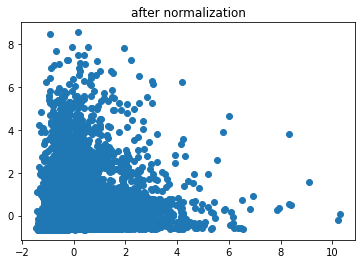

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X_train.T[0], X_train.T[2000])
plt.title('after normalization')
plt.show()

# Training Deep autoencoder for all samples

In [6]:
def autoencoder_model(original_dim=23075, intermediate1_dim=256, intermediate2_dim=128, latent_dim=32, l2=0.001):
  
  initializer = tf.keras.initializers.HeNormal()
  regularizer = tf.keras.regularizers.L2(l2)
  
  x = Input(shape=(original_dim, ))

  net = Dense(intermediate1_dim,kernel_initializer=initializer)(x)
  net2 = BatchNormalization()(net)
  net3 = Activation('relu')(net2)

  net4 = Dense(intermediate2_dim,kernel_initializer=initializer)(net3)
  net5 = BatchNormalization()(net4)
  net6 = Activation('relu')(net5)

  z = Dense(latent_dim, activation='relu',kernel_initializer=initializer)(net6)

  #Define decoder
  decoder_h = Dense(intermediate2_dim, activation='relu', kernel_initializer=initializer)
  decoder_h2 = Dense(intermediate1_dim, activation='relu',kernel_initializer=initializer)
  decoder_mean = Dense(original_dim,kernel_initializer=initializer)

  h_decoded = decoder_h(z)
  h_decoded2 = decoder_h2(h_decoded)
  x_decoded_mean = decoder_mean(h_decoded2)

  autoencoder =  Model(x, x_decoded_mean)

  return autoencoder

In [9]:
if 1:
  latent_dim=128
  original_dim = len(X_train[1])
  lr=0.001

  #autoencoder = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder_latent{}_lr{}.h5'.format(latent_dim,lr))

  optimizer = tf.optimizers.Adam(learning_rate=lr)
  autoencoder = autoencoder_model(original_dim=original_dim, intermediate1_dim=512, intermediate2_dim=256, latent_dim=latent_dim, l2=0.01)
  autoencoder.compile(optimizer=optimizer, loss='mse')

  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, mode='min')
  checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder2_512-256-{}_initHe_lr{}.h5'.format(latent_dim,lr), 
                                               monitor='val_loss', mode='min',
                                               verbose=1, save_best_only=True) 

  history=autoencoder.fit(X_train, X_train, 
                          validation_data = [X_val, X_val],
                          epochs=1000000, 
                          batch_size=10000, 
                          callbacks=[early_stop, checkpoint],
                          )

Streaming output truncated to the last 5000 lines.
Epoch 3031/1000000
2/2 [==============================] - ETA: 0s - loss: 0.1280
Epoch 3031: val_loss improved from 0.15819 to 0.15815, saving model to /content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder2_512-256-128_initHe_lr0.001.h5
2/2 [==============================] - 2s 1s/step - loss: 0.1280 - val_loss: 0.1582
Epoch 3032/1000000
2/2 [==============================] - ETA: 0s - loss: 0.1278
Epoch 3032: val_loss did not improve from 0.15815
2/2 [==============================] - 1s 572ms/step - loss: 0.1278 - val_loss: 0.1583
Epoch 3033/1000000
2/2 [==============================] - ETA: 0s - loss: 0.1280
Epoch 3033: val_loss did not improve from 0.15815
2/2 [==============================] - 1s 593ms/step - loss: 0.1280 - val_loss: 0.1583
Epoch 3034/1000000
2/2 [==============================] - ETA: 0s - loss: 0.1280
Epoch 3034: val_loss did not improve from 0.15815
2/2 [==============================] - 1s 552ms/step - los

In [16]:
def autoencoder_model(original_dim=23075, intermediate1_dim=256, intermediate2_dim=128, intermediate3_dim=16, latent_dim=8):
  initializer = tf.keras.initializers.HeNormal()
  
  x = Input(shape=(original_dim, ))

  net = Dense(intermediate1_dim,kernel_initializer=initializer)(x)
  net = BatchNormalization()(net)
  net = Activation('relu')(net)

  net = Dense(intermediate2_dim,kernel_initializer=initializer)(net)
  net = BatchNormalization()(net)
  net = Activation('relu')(net)

  net = Dense(intermediate3_dim,kernel_initializer=initializer)(net)
  net = BatchNormalization()(net)
  net = Activation('relu')(net)

  z = Dense(latent_dim, activation='relu',kernel_initializer=initializer)(net)

  #Define decoder
  h_decoded = Dense(intermediate3_dim, activation='relu', kernel_initializer=initializer)(z)
  h_decoded = Dense(intermediate2_dim, activation='relu', kernel_initializer=initializer)(h_decoded)
  h_decoded = Dense(intermediate1_dim, activation='relu',kernel_initializer=initializer)(h_decoded)
  x_decoded_mean = Dense(original_dim,kernel_initializer=initializer)(h_decoded)

  autoencoder =  Model(x, x_decoded_mean)
  return autoencoder


################################################################################
########################     Training autoencoder    ###########################
################################################################################

latent_dim=8
original_dim = len(X_train[1])
lr=0.001

optimizer = tf.optimizers.Adam(learning_rate=lr)
autoencoder = autoencoder_model(original_dim=original_dim, 
                                intermediate1_dim=512, intermediate2_dim=128, intermediate3_dim=32, latent_dim=latent_dim)
autoencoder.compile(optimizer=optimizer, loss='mse')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, mode='min')
checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder2_512-128-32-{}_initHe_lr{}.h5'.format(latent_dim,lr), 
                                               monitor='val_loss', mode='min',
                                               verbose=1, save_best_only=True) 

history=autoencoder.fit(X_train, X_train, validation_data = [X_val, X_val],
                        epochs=1000000, batch_size=10000, 
                        callbacks=[early_stop, checkpoint]
                        )

Streaming output truncated to the last 5000 lines.
Epoch 4054/1000000
2/2 [==============================] - ETA: 0s - loss: 0.1710
Epoch 4054: val_loss did not improve from 0.20733
2/2 [==============================] - 1s 557ms/step - loss: 0.1710 - val_loss: 0.2087
Epoch 4055/1000000
2/2 [==============================] - ETA: 0s - loss: 0.1710
Epoch 4055: val_loss did not improve from 0.20733
2/2 [==============================] - 1s 537ms/step - loss: 0.1710 - val_loss: 0.2086
Epoch 4056/1000000
2/2 [==============================] - ETA: 0s - loss: 0.1710
Epoch 4056: val_loss did not improve from 0.20733
2/2 [==============================] - 1s 638ms/step - loss: 0.1710 - val_loss: 0.2079
Epoch 4057/1000000
2/2 [==============================] - ETA: 0s - loss: 0.1706
Epoch 4057: val_loss did not improve from 0.20733
2/2 [==============================] - 1s 591ms/step - loss: 0.1706 - val_loss: 0.2079
Epoch 4058/1000000
2/2 [==============================] - ETA: 0s - loss: 0.1

In [ ]:
for latent_dim in [16,8]:
  #latent_dim=32
  original_dim = len(X_train[1])
  lr=0.001

  #autoencoder = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder_latent{}_lr{}.h5'.format(latent_dim,lr))

  optimizer = tf.optimizers.Adam(learning_rate=lr)
  autoencoder = autoencoder_model(original_dim=original_dim, intermediate1_dim=512, intermediate2_dim=128, latent_dim=latent_dim)
  autoencoder.compile(optimizer=optimizer, loss='mse')

  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, mode='min')
  checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder_latent{}_lr{}.h5'.format(latent_dim,lr), 
                                               monitor='val_loss', mode='min',
                                               verbose=1, save_best_only=True) 

  history=autoencoder.fit(X_train, X_train, 
                          validation_data = [X_val, X_val],
                          epochs=1000000, 
                          batch_size=5000, 
                          callbacks=[early_stop, checkpoint],
                          )

In [ ]:
plot_track_autoencoder(history)

# Validate autoencoder

In [6]:
import numpy as np
import pandas as pd
!cp /content/drive/MyDrive/muscle_promoter/utils.py .
from utils import *

In [7]:
X_train = np.load('/content/drive/MyDrive/muscle_promoter/training_data/X_train.npy', allow_pickle=True)
X_val = np.load('/content/drive/MyDrive/muscle_promoter/training_data/X_val.npy', allow_pickle=True)
X_test = np.load('/content/drive/MyDrive/muscle_promoter/training_data/X_test.npy', allow_pickle=True)

X_train, X_val, X_test = normalize_data(X_train, X_val, X_test)
print(X_train.shape, X_val.shape, X_test.shape)

(14082, 23075) (3000, 23075) (150, 23075)


In [26]:
from tensorflow import keras

latent_dim=16
lr=0.001

autoencoder = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder2_512-256-128_initHe_lr0.001.h5')
#autoencoder.summary()

X_train_pred = autoencoder.predict(X_train)
X_val_pred = autoencoder.predict(X_val)
X_test_pred = autoencoder.predict(X_test)

In [20]:
from sklearn.metrics import r2_score

print(
    r2_score(X_train, X_train_pred, multioutput='variance_weighted'),
    r2_score(X_val, X_val_pred, multioutput='variance_weighted'),
    r2_score(X_test, X_test_pred, multioutput='variance_weighted')
)

0.8466186479403579 0.8100741638807364 0.8183293054358418


In [27]:
from sklearn.metrics import r2_score

print(
    r2_score(X_train, X_train_pred, multioutput='uniform_average'),
    r2_score(X_val, X_val_pred, multioutput='uniform_average'),
    r2_score(X_test, X_test_pred, multioutput='uniform_average')
)

0.8762592477344799 0.8523293469044143 0.7998351649583727


In [17]:
def mean_corr_spearmanr(X_test, X_test_pred):
  from scipy.stats import spearmanr
  r=[]
  for i in range(len(X_test)):
    rho = spearmanr(X_test.T[i], X_test_pred.T[i])[0]
    r.append(rho)
  return sum(r)/len(r)
  
print(mean_corr_spearmanr(X_train, X_train_pred), 
      mean_corr_spearmanr(X_val, X_val_pred), 
      mean_corr_spearmanr(X_test, X_test_pred))

0.834950141512593 0.8166345925422991 0.8347994327159051


In [28]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(X_train, X_train_pred), 
      mean_squared_error(X_val, X_val_pred), 
      mean_squared_error(X_test, X_test_pred))

0.12374075226552017 0.1558687844457424 0.15666911809478856


In [ ]:
import matplotlib.pyplot as plt

i=4000
plt.scatter(X_train.T[i], X_train_pred.T[i])
plt.scatter(X_val.T[i], X_val_pred.T[i])
plt.scatter(X_test.T[i], X_test_pred.T[i])
plt.xlabel('true values')
plt.ylabel('prediced values')
plt.show()


# extract latent space

In [ ]:
#extract latent space
from tensorflow import keras
from keras.models import Model

latent_dim=32
lr=0.001

autoencoder = keras.models.load_model('/content/drive/MyDrive/muscle_promoter/GTEx8_autoencoder_latent{}_lr{}.h5'.format(latent_dim,lr))

#extract encoder layers
encoder = Model(autoencoder.input, autoencoder.layers[-4].output)
latent = encoder.predict(X_test)

In [ ]:
latent.shape

(150, 32)

In [ ]:
latent[2]

array([1.906864 , 2.8980207, 1.3589131, 2.087931 , 1.0195652, 4.229236 ,
       2.8731558, 3.4246254, 2.1487594, 2.375274 , 3.140921 , 2.9216418,
       3.9298663, 1.6436977, 1.2858273, 9.021949 , 9.247577 , 2.6544645,
       1.3320328, 1.9983566, 2.2743206, 1.4298624, 1.2977073, 1.6824409,
       2.1102836, 2.6515563, 4.996764 , 2.647267 , 0.       , 0.       ,
       4.5253687, 8.74857  ], dtype=float32)